## Creating the Dense and CNN models for Author Identification

**THIS NOTEBOOK ISN'T MEANT TO BE RUN.** It contains teaching of various Neural Networks for proof that we have done what we claim to have done.

Firstly, we'll load in all the necessary packages:

In [1]:
import warnings
warnings.filterwarnings('ignore')
from numpy.random import seed
seed(1)

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from nltk.tokenize import sent_tokenize,word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import nltk
from nltk.corpus import stopwords

from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from keras.callbacks import EarlyStopping

from sklearn.preprocessing import StandardScaler

import pickle

nltk.download('punkt')
nltk.download('stopwords')
#np.random.seed(1)
random_state = 7

Using TensorFlow backend.
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\AMD\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\AMD\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Then we'll load in the train and test datasets:

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [4]:
train.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [5]:
test.head()

,id,text
0,id02310,"Still, as I urged our leaving Ireland with suc..."
1,id24541,"If a fire wanted fanning, it could readily be ..."
2,id00134,And when they had broken down the frail door t...
3,id27757,While I was thinking how I should possibly man...
4,id04081,I am not sure to what limit his knowledge may ...


Some simple statistics about each author:

In [6]:
train['sentences'] = train.text.transform(lambda x: len(sent_tokenize(x)))
train['words'] = train.text.transform(lambda x: len(word_tokenize(x)))
train['text_length'] = train.text.transform(lambda x: len(x))

text_info = train.groupby("author")[['sentences','words','text_length']].sum()
text_info

,sentences,words,text_length
author,,,
EAP,8206,232135,1123585
HPL,5876,174045,878178
MWS,6128,188827,916632


### Data manipulation

In this part, we're applying multiple types of data transformations:
- Encoding each author as 0, 1 or 2;
- Tokenizing each sentence;
- Removing stopwords;
- Creating a validation set, since the *test* set didn't include actual labels.

In [7]:
stop_words = set(stopwords.words('english')).union(set([',','.','?','!',':',';',"'",'"','-',"''","`","``"]))
author_dict = {'EAP': 0, 'HPL': 1, 'MWS': 2}

In [8]:
new_text = []
new_author = []
for i, row in train[['text','author']].iterrows():
    word_tokens = word_tokenize(row['text'])
    new_text.append(" ".join([w for w in word_tokens if not w in stop_words]))
    new_author.append(author_dict[row['author']])
new_train = pd.DataFrame(data={'text': new_text, 'author': new_author})

In [9]:
new_test_text = []
for i, row in test[['text']].iterrows():
    word_tokens = word_tokenize(row['text'])
    new_test_text.append(" ".join([w for w in word_tokens if not w in stop_words]))
new_test = pd.DataFrame(data={'text': new_text})

In [10]:
X = new_train['text']
y = new_train['author']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=random_state)
X_test = new_test['text']

In [11]:
new_text_ws = [] # without stopwords
for i, row in train[['text']].iterrows():
    word_tokens = word_tokenize(row['text'])
    new_text_ws.append(" ".join([w for w in word_tokens if not w in [',','.','?','!',':',';',"'",'"','-',"''","`","``"]]).lower())
new_train_ws = pd.DataFrame(data={'text': new_text_ws, 'author': new_author})

In [12]:
X_ws = new_train_ws['text']
y_ws = new_train_ws['author']
X_ws_train, X_ws_valid, y_ws_train, y_ws_valid = train_test_split(X_ws, y_ws, test_size=0.3, random_state=random_state)

In [13]:
X_ws.head()

0    this process however afforded me no means of a...
1    it never once occurred to me that the fumbling...
2    in his left hand was a gold snuff box from whi...
3    how lovely is spring as we looked from windsor...
4    finding nothing else not even gold the superin...
Name: text, dtype: object

In [14]:
new_train

,text,author
0,This process however afforded means ascertaini...,0
1,It never occurred fumbling might mere mistake,1
2,In left hand gold snuff box capered hill cutti...,0
3,How lovely spring As looked Windsor Terrace si...,2
4,Finding nothing else even gold Superintendent ...,1
...,...,...
19574,I could fancied I looked eminent landscape pai...,0
19575,The lids clenched together spasm,0
19576,Mais il faut agir say Frenchman never faints o...,0
19577,For item news like strikes us coolly received,0


In [15]:
X_train_list = list(X_train)
y_train_list = list(y_train)
X_valid_list = list(X_valid)
y_valid_list = list(y_valid)

In [16]:
X_ws_train_list = list(X_ws_train)
y_ws_train_list = list(y_ws_train)
X_ws_valid_list = list(X_ws_valid)
y_ws_valid_list = list(y_ws_valid)

In [17]:
y_ws_train_list = np.array(y_ws_train_list)
y_ws_valid_list = np.array(y_ws_valid_list)

In [18]:
y_ws_train_list[:50]

array([0, 0, 1, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 1, 2, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 1, 1, 0, 1, 0, 1, 2, 0, 1, 1, 2, 0,
       0, 1, 2, 2, 2, 0])

### Defining the doc2vec model

In [19]:
for i, doc in enumerate(common_texts):
    print(doc, [i])

['human', 'interface', 'computer'] [0]
['survey', 'user', 'computer', 'system', 'response', 'time'] [1]
['eps', 'user', 'interface', 'system'] [2]
['system', 'human', 'system', 'eps'] [3]
['user', 'response', 'time'] [4]
['trees'] [5]
['graph', 'trees'] [6]
['graph', 'minors', 'trees'] [7]
['graph', 'minors', 'survey'] [8]


In [20]:
for i, doc in enumerate(X_ws_train_list[:10]):
    print(doc.split(), i)

['should', 'any', 'one', 'wish', 'to', 'purchase', 'or', 'to', 'inquire', 'the', 'price', 'of', 'an', 'article', 'a', 'bell', 'is', 'at', 'hand', 'and', 'this', 'is', 'considered', 'amply', 'sufficient'] 0
['he', 'said', 'that', 'some', 'person', 'apparently', 'in', 'great', 'haste', 'demanded', 'to', 'speak', 'with', 'me', 'in', 'the', 'hall'] 1
['but', 'still', 'there', 'remained', 'that', 'burning', 'determination', 'to', 'reach', 'the', 'innermost', 'secret', 'of', 'the', 'fear', 'which', 'i', 'had', 'once', 'more', 'come', 'to', 'deem', 'definite', 'material', 'and', 'organic'] 2
['a', 'letter', 'may', 'be', 'compressed', 'into', 'a', 'thin', 'spiral', 'roll', 'not', 'differing', 'much', 'in', 'shape', 'or', 'bulk', 'from', 'a', 'large', 'knitting', 'needle', 'and', 'in', 'this', 'form', 'it', 'might', 'be', 'inserted', 'into', 'the', 'rung', 'of', 'a', 'chair', 'for', 'example'] 3
['he', 'discoursed', 'much', 'and', 'beyond', 'doubt', 'learnedly', 'while', 'i', 'hazarded', 'an', 

In [21]:
X_ws_train_list[0].split()[0]

'should'

### Pre-trained fastText vectors

Similarly to the Evaluation Notebook, we need to download the FastText vectors provided by Gensim, however, we have already saved these into a separate file and it's much faster to load that way.

In [22]:
# import gensim.downloader

In [23]:
# fasttext_vectors = gensim.downloader.load('fasttext-wiki-news-subwords-300')

In [24]:
#with open('fasttext_vectors.pickle', 'wb') as f:
#    pickle.dump(fasttext_vectors, f)

In [25]:
with open("fasttext_vectors.pickle", 'rb') as f:
    fasttext_vectors = pickle.load(f)

In [26]:
np.array(fasttext_vectors.wv[X_ws_train_list[0].split()[0]])

C:\Users\AMD\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


array([-1.0834e-02, -5.6953e-02, -3.1731e-02,  2.6749e-02,  4.7278e-02,
        4.2279e-03,  8.8756e-03, -8.3149e-02, -5.7365e-02, -4.3851e-02,
        1.0353e-02,  9.5677e-03,  1.5618e-02, -5.1344e-03,  2.6610e-02,
       -2.0032e-03,  1.2627e-01, -3.4053e-02,  7.2836e-02, -2.9336e-02,
        1.2728e-02, -5.9716e-02,  4.7661e-02,  8.5972e-02, -3.9190e-02,
       -7.3656e-03, -1.8250e-02,  2.8804e-02, -1.9875e-02, -2.4632e-02,
       -3.5466e-02, -2.4895e-02,  4.0472e-02,  6.5614e-02,  2.6882e-02,
       -8.2732e-02, -9.4424e-03, -2.4687e-02, -4.3293e-02,  1.7315e-02,
       -5.1753e-02, -1.6385e-02, -1.0530e-02, -1.6188e-02, -3.0672e-02,
       -1.8272e-03, -9.3336e-03, -1.5161e-02,  1.1667e-01, -4.2138e-04,
        9.3487e-03, -1.1487e-02, -5.4632e-02, -3.8202e-03, -2.2158e-01,
        3.0325e-02,  1.5373e-02,  1.8478e-02, -9.8686e-02, -2.1137e-02,
       -1.9092e-02,  1.4057e-02,  1.1103e-01, -2.9714e-02,  4.2807e-02,
       -5.1898e-02, -9.7448e-03,  5.6202e-03,  1.5102e-02, -7.24

### Unifying sentence length and creating average vectors

In [27]:
X_ws_train_ft_mean_vectors = np.empty([len(X_ws_train_list), 300])
for j in range(len(X_ws_train_list)):
    X_ws_train_ft_vectors = np.empty([len(X_ws_train_list[j].split()), 300])
    for i in range(len(X_ws_train_list[j].split())):
        try:
            X_ws_train_ft_vectors[i] = fasttext_vectors.wv[X_ws_train_list[j].split()[i]]
        except KeyError:
            X_ws_train_ft_vectors[i] = np.zeros(300)
    X_ws_train_ft_mean_vectors[j] = np.mean(X_ws_train_ft_vectors, axis=0)

C:\Users\AMD\anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


In [28]:
scaler = StandardScaler()
X_ws_train_ft_mean_vectors = scaler.fit_transform(X_ws_train_ft_mean_vectors)

In [29]:
X_ws_valid_ft_mean_vectors = np.empty([len(X_ws_valid_list), 300])
for j in range(len(X_ws_valid_list)):
    X_ws_valid_ft_vectors = np.empty([len(X_ws_valid_list[j].split()), 300])
    for i in range(len(X_ws_valid_list[j].split())):
        try:
            X_ws_valid_ft_vectors[i] = fasttext_vectors.wv[X_ws_valid_list[j].split()[i]]
        except KeyError:
            X_ws_valid_ft_vectors[i] = np.zeros(300)
    X_ws_valid_ft_mean_vectors[j] = np.mean(X_ws_valid_ft_vectors, axis=0)

C:\Users\AMD\anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


In [30]:
scaler = StandardScaler()
X_ws_valid_ft_mean_vectors = scaler.fit_transform(X_ws_valid_ft_mean_vectors)

In [31]:
len(X_ws_train_list)

13705

In [32]:
documents = [TaggedDocument(doc.split(), [i]) for i, doc in enumerate(X_ws_train_list)]
model = Doc2Vec(documents, vector_size=100, window=2, min_count=1, workers=4)

In [34]:
model.infer_vector([X_ws_train_list[0]])

array([-2.9918887e-03, -3.8555879e-03, -2.5199535e-03,  7.2088485e-05,
        3.8668111e-03,  3.8766544e-03, -1.0412795e-03, -3.0497813e-03,
       -3.2655792e-03,  1.9558675e-03,  4.9269721e-03, -6.2503917e-05,
        1.7103464e-03, -4.2067157e-04,  1.4984971e-03,  1.2264730e-03,
        2.0480684e-03, -4.4938531e-03,  4.7159181e-03,  2.2558835e-03,
        4.2556333e-03, -4.0373835e-04,  1.8219735e-03,  3.9789118e-03,
       -2.3151303e-03, -1.2586162e-03, -3.2142217e-03,  4.8896349e-03,
        2.6925153e-03, -8.9307071e-04,  2.3907372e-03, -2.7142793e-03,
       -3.8408348e-03,  4.6895890e-05, -3.1993315e-03,  4.6548210e-03,
       -2.3301060e-03,  4.3738412e-04, -3.5655946e-03,  3.0774908e-04,
        3.4242175e-03, -1.8653512e-03,  1.3168417e-03, -2.5733355e-03,
       -1.0467713e-03,  2.9610416e-03, -4.6788943e-03,  1.9721668e-03,
        3.0607267e-03, -2.8135886e-03, -3.9678463e-03,  2.5376235e-03,
       -1.3786314e-04,  4.3326560e-03,  3.4382606e-03,  1.6738891e-03,
      

### Using word2vec and scaling the data with a Standard Scaler

In [35]:
X_ws_train_vectors = np.empty([len(X_ws_train_list), 100])
for i in range(len(X_ws_train_list)):
    X_ws_train_vectors[i] = model.infer_vector([X_ws_train_list[i]])

In [36]:
X_ws_valid_vectors = np.empty([len(X_ws_valid_list), 100])
for i in range(len(X_ws_valid_list)):
    X_ws_valid_vectors[i] = model.infer_vector([X_ws_valid_list[i]])

In [37]:
scaler = StandardScaler()
X_ws_train_vectors = scaler.fit_transform(X_ws_train_vectors)

In [38]:
scaler = StandardScaler()
X_ws_valid_vectors = scaler.fit_transform(X_ws_valid_vectors)

In [39]:
X_ws_train_vectors.shape

(13705, 100)

In [40]:
len(X_ws_train_list), len(X_ws_train_ft_mean_vectors)

(13705, 13705)

In [41]:
X_ws_train_vectors[0].shape # the input shape

(100,)

In [42]:
from keras.utils import to_categorical
y_ws_train_list = to_categorical(y_ws_train_list)
y_ws_valid_list = to_categorical(y_ws_valid_list)

In [43]:
y_ws_train_list[:5]

array([[1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

### Defining a simple Dense Model

In [44]:
dense_model = tf.keras.models.Sequential()
dense_model.add(tf.keras.Input(shape=(300,)))
dense_model.add(tf.keras.layers.Dense(320, activation='relu', kernel_initializer='he_normal'))
dense_model.add(tf.keras.layers.Dense(320, activation='relu', kernel_initializer='he_normal'))
dense_model.add(tf.keras.layers.Dropout(0.75))
dense_model.add(tf.keras.layers.Dense(320, activation='relu', kernel_initializer='he_normal'))
dense_model.add(tf.keras.layers.Dense(3, activation='softmax'))
dense_model.output_shape

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


(None, 3)

In [45]:
dense_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 320)               96320     
_________________________________________________________________
dense_1 (Dense)              (None, 320)               102720    
_________________________________________________________________
dropout (Dropout)            (None, 320)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 320)               102720    
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 963       
Total params: 302,723
Trainable params: 302,723
Non-trainable params: 0
_________________________________________________________________


In [42]:
early_stopping=EarlyStopping(monitor="val_loss",patience=10,verbose=1,restore_best_weights=True)

In [43]:
dense_model.compile(optimizer=Adam(lr=1e-4),loss='categorical_crossentropy',metrics=['accuracy'])

In [44]:
dense_model.fit(X_ws_train_ft_mean_vectors, y_ws_train_list,  validation_split = 0.2,
                     callbacks=[early_stopping], epochs=250)

Train on 10964 samples, validate on 2741 samples
Epoch 1/250
10964/10964 [==============================] - 7s 602us/sample - loss: 1.5211 - acc: 0.4179 - val_loss: 0.9861 - val_acc: 0.5348
Epoch 2/250
10964/10964 [==============================] - 6s 524us/sample - loss: 1.1150 - acc: 0.4944 - val_loss: 0.9094 - val_acc: 0.5779
Epoch 3/250
10964/10964 [==============================] - 6s 544us/sample - loss: 1.0090 - acc: 0.5426 - val_loss: 0.8709 - val_acc: 0.6133
Epoch 4/250
10964/10964 [==============================] - 7s 620us/sample - loss: 0.9490 - acc: 0.5737 - val_loss: 0.8293 - val_acc: 0.6312
Epoch 5/250
10964/10964 [==============================] - 8s 745us/sample - loss: 0.8969 - acc: 0.5981 - val_loss: 0.8121 - val_acc: 0.6421
Epoch 6/250
10964/10964 [==============================] - 11s 961us/sample - loss: 0.8627 - acc: 0.6139 - val_loss: 0.7867 - val_acc: 0.6625
Epoch 7/250
10964/10964 [==============================] - 7s 645us/sample - loss: 0.8239 - acc: 0.6416 

In [45]:
score = dense_model.evaluate(X_ws_valid_ft_mean_vectors, y_ws_valid_list, verbose = 0)
print("Test score: ", score[0])
print("Test accuracy: ", score[1])

Test score:  0.7087346330300293
Test accuracy:  0.7419135


Adam lr=1e-03: Test score:  1.6695 Test accuracy:  0.7431 <br>
Adam lr=1e-04: Test score:  1.3782 Test accuracy:  0.7233 <br>
Adam lr=1e-05 (75 epochs):  Test score:  0.7557 Test accuracy:  0.7211 <br>

### Defining various CNN models

In [45]:
cutoff = 100

Data transformation for the CNN model (detailed in section 3.3.1 of our report PDF):

In [46]:
def shorten(X_input_sentences, y_input_labels, length):
    X_out = []
    y_out = []
    for i in range(len(X_input_sentences)):
        if len(X_input_sentences[i].split(' ')) <= length:
            X_out.append(X_input_sentences[i])
            y_out.append(y_input_labels[i])
    return X_out, np.array(y_out)

X_ws_train_list_short, y_ws_train_list_short = shorten(X_ws_train_list,y_ws_train_list,cutoff)
X_ws_valid_list_short, y_ws_valid_list_short = shorten(X_ws_valid_list,y_ws_valid_list,cutoff)

In [47]:
def set_of_sentences_to_vec(orig_list, vec_length, cutoff):

    out = np.empty([len(orig_list), cutoff, vec_length])

    for j in range(len(orig_list)):
        add_vectors = np.empty([cutoff, vec_length])
        
        sentence_length = len(orig_list[j].split()) + 1
        
        for i in range(cutoff):
            cur_split_sentence = orig_list[j].split() + [' ']
            try:
                add_vectors[i] = fasttext_vectors.wv[cur_split_sentence[i % sentence_length]]
            except KeyError:
                add_vectors[i] = np.zeros(vec_length)

        out[j] = add_vectors
  
    return out

X_ws_train_ft_all_vectors = set_of_sentences_to_vec(X_ws_train_list_short, 300, cutoff)
X_ws_valid_ft_all_vectors = set_of_sentences_to_vec(X_ws_valid_list_short, 300, cutoff)

C:\Users\AMD\anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  del sys.path[0]


In [48]:
X_ws_train_ft_all_vectors.shape

(13640, 100, 300)

In [49]:
X_ws_valid_ft_all_vectors.shape

(5850, 100, 300)

In [50]:
X_ws_train_ft_all_vectors_tp = np.transpose(X_ws_train_ft_all_vectors,axes=(0,2,1))
X_ws_valid_ft_all_vectors_tp = np.transpose(X_ws_valid_ft_all_vectors,axes=(0,2,1))

In [51]:
X_ws_train_ft_all_vectors_tp.shape

(13640, 300, 100)

In [52]:
X_ws_valid_ft_all_vectors_tp.shape

(5850, 300, 100)

In [53]:
conv_model = tf.keras.models.Sequential()
conv_model.add(tf.keras.layers.Conv1D(300,kernel_size=7,
        input_shape=(100,300), activation='relu',
        kernel_regularizer=regularizers.l1_l2(l1=1e-4, l2=1e-3),
        bias_regularizer=regularizers.l2(1e-3),
        activity_regularizer=regularizers.l2(1e-4)))
conv_model.add(tf.keras.layers.Flatten())
conv_model.add(tf.keras.layers.Dense(94, activation='relu',
        kernel_regularizer=regularizers.l1_l2(l1=1e-4, l2=1e-3),
        bias_regularizer=regularizers.l2(1e-3),
        activity_regularizer=regularizers.l2(1e-4)))
conv_model.add(tf.keras.layers.Dropout(0.4))
conv_model.add(tf.keras.layers.Dense(3, activation='softmax'))
conv_model.output_shape

(None, 3)

In [54]:
conv_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 94, 300)           630300    
_________________________________________________________________
flatten (Flatten)            (None, 28200)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 94)                2650894   
_________________________________________________________________
dropout_1 (Dropout)          (None, 94)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 285       
Total params: 3,281,479
Trainable params: 3,281,479
Non-trainable params: 0
_________________________________________________________________


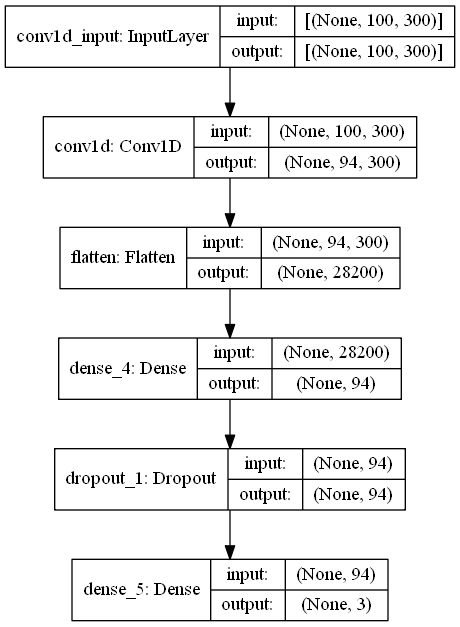

In [55]:
plot_model(conv_model, to_file='conv_model_plot.png', show_shapes=True, show_layer_names=True)

In [56]:
conv_model.compile(optimizer='adam',loss='categorical_crossentropy' ,metrics=['accuracy'])

In [57]:
inp = tf.keras.Input(shape=(300,100), name='input')

def conv_pool_layer(kernel_size,input_layer,name):
    
    conv = tf.keras.layers.Conv1D(100,kernel_size=kernel_size,
        input_shape=(300,100), activation='relu', padding='same',
        kernel_regularizer=regularizers.l1_l2(l1=1e-4, l2=1e-3),
        bias_regularizer=regularizers.l2(1e-3),
        activity_regularizer=regularizers.l2(1e-4),
        data_format='channels_last', name='1D_conv' + name)(input_layer)

    return conv

model3 = tf.keras.Model(inputs=inp, outputs=conv_pool_layer(3,inp,'3'))
model5 = tf.keras.Model(inputs=inp, outputs=conv_pool_layer(5,inp,'5'))
model7 = tf.keras.Model(inputs=inp, outputs=conv_pool_layer(7,inp,'7'))
model9 = tf.keras.Model(inputs=inp, outputs=conv_pool_layer(9,inp,'9'))

combined = tf.keras.layers.concatenate([model3.output, model5.output,
                                        model7.output, model9.output], name='concatenate')

flat = tf.keras.layers.Flatten(name='flatten')(combined)
drop = tf.keras.layers.Dropout(0.67,name='droput_0.67')(flat)
dense = tf.keras.layers.Dense(3, activation='softmax',name='dense')(drop)

conv_model2 = tf.keras.Model(inputs=[model3.input],
                            outputs=dense,name='Multiconv_Model')
conv_model2.output_shape

(None, 3)

In [58]:
conv_model2.summary()

Model: "Multiconv_Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 300, 100)]   0                                            
__________________________________________________________________________________________________
1D_conv3 (Conv1D)               (None, 300, 100)     30100       input[0][0]                      
__________________________________________________________________________________________________
1D_conv5 (Conv1D)               (None, 300, 100)     50100       input[0][0]                      
__________________________________________________________________________________________________
1D_conv7 (Conv1D)               (None, 300, 100)     70100       input[0][0]                      
____________________________________________________________________________________

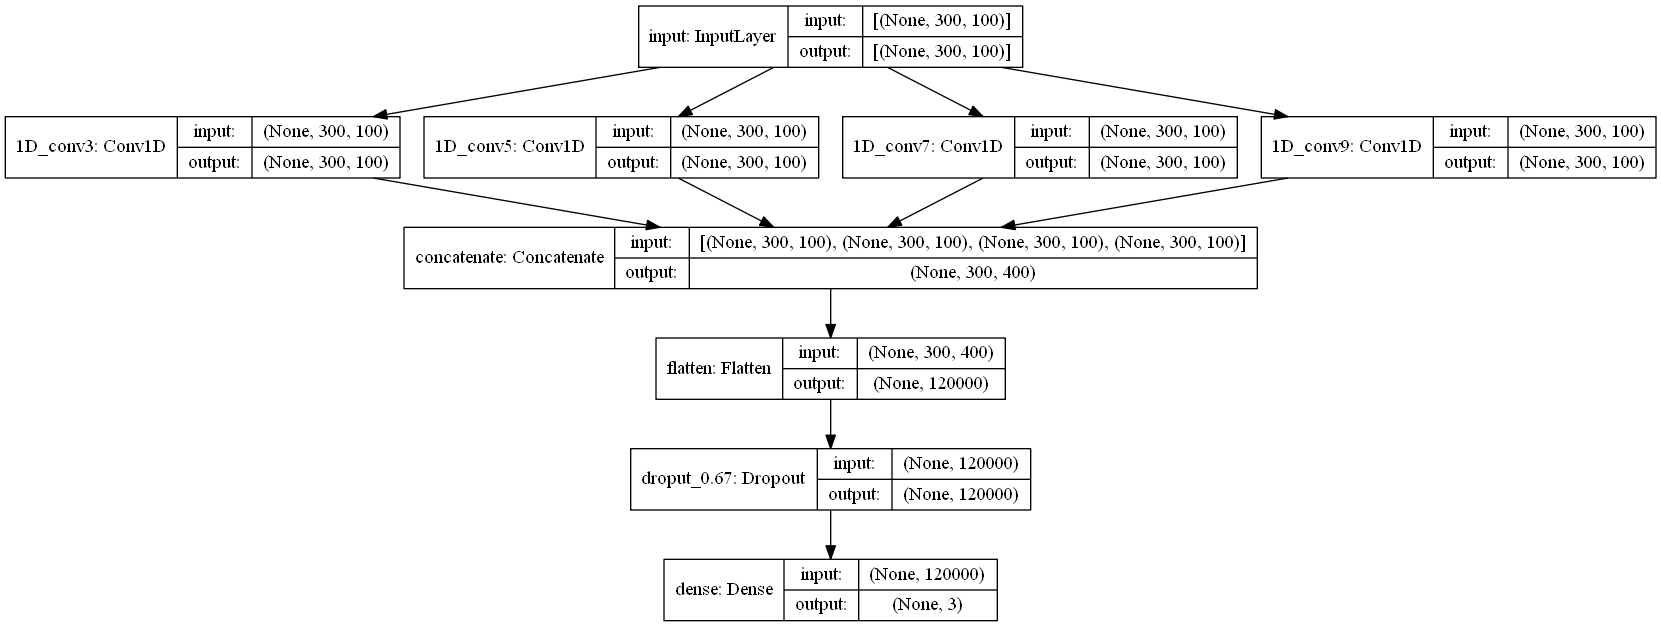

In [59]:
plot_model(conv_model2, to_file='multiconv_model_plot.png', show_shapes=True, show_layer_names=True)

Using **Early Stopping** to stop the learning early and **restore all the best possible weights** found in a certain epoch:

In [62]:
early_stopping=EarlyStopping(monitor="val_loss",patience=5,verbose=1,restore_best_weights=True)

In [63]:
conv_model2.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

In [63]:
for i in range(8):
    print("SESSION " + str(i)) 
    conv_model.fit(X_ws_train_ft_all_vectors, y_ws_train_list_short,
                   epochs=5, batch_size=20, validation_split=1/11, callbacks=[early_stopping])
    conv_model.save('author_identification_conv3_model' + str(i) + '.h5')

SESSION 0
Train on 12400 samples, validate on 1240 samples
Epoch 1/5
12400/12400 [==============================] - 784s 63ms/sample - loss: 1.1951 - acc: 0.5371 - val_loss: 0.9324 - val_acc: 0.6121
Epoch 2/5
12400/12400 [==============================] - 766s 62ms/sample - loss: 0.9099 - acc: 0.6631 - val_loss: 0.8844 - val_acc: 0.6903
Epoch 3/5
12400/12400 [==============================] - 779s 63ms/sample - loss: 0.8916 - acc: 0.6908 - val_loss: 0.9266 - val_acc: 0.6710
Epoch 4/5
12400/12400 [==============================] - 762s 61ms/sample - loss: 0.8824 - acc: 0.7069 - val_loss: 0.8673 - val_acc: 0.7024
Epoch 5/5
12400/12400 [==============================] - 726s 59ms/sample - loss: 0.8455 - acc: 0.7203 - val_loss: 0.8620 - val_acc: 0.7073
SESSION 1
Train on 12400 samples, validate on 1240 samples
Epoch 1/5
12400/12400 [==============================] - 737s 59ms/sample - loss: 0.8460 - acc: 0.7276 - val_loss: 0.8385 - val_acc: 0.7145
Epoch 2/5
12400/12400 [===================

KeyboardInterrupt: 

In [63]:
for i in range(8):
    print("SESSION " + str(i)) 
    conv_model2.fit(X_ws_train_ft_all_vectors_tp, y_ws_train_list_short,
                   epochs=5, batch_size=20, validation_split=1/11, callbacks=[early_stopping])
    conv_model2.save('author_identification_multiconv5_model' + str(i) + '.h5')

SESSION 0
Train on 12400 samples, validate on 1240 samples
Epoch 1/5
12400/12400 [==============================] - 837s 68ms/sample - loss: 1.5418 - acc: 0.5183 - val_loss: 1.1116 - val_acc: 0.6105
Epoch 2/5
12400/12400 [==============================] - 776s 63ms/sample - loss: 0.9945 - acc: 0.6448 - val_loss: 0.9333 - val_acc: 0.6492
Epoch 3/5
12400/12400 [==============================] - 771s 62ms/sample - loss: 0.9074 - acc: 0.6681 - val_loss: 0.9067 - val_acc: 0.6645
Epoch 4/5
12400/12400 [==============================] - 767s 62ms/sample - loss: 0.8774 - acc: 0.6905 - val_loss: 0.9301 - val_acc: 0.6508
Epoch 5/5
12400/12400 [==============================] - 763s 61ms/sample - loss: 0.8465 - acc: 0.7076 - val_loss: 0.8968 - val_acc: 0.6895
SESSION 1
Train on 12400 samples, validate on 1240 samples
Epoch 1/5
12400/12400 [==============================] - 764s 62ms/sample - loss: 0.8312 - acc: 0.7211 - val_loss: 0.9624 - val_acc: 0.6395
Epoch 2/5
12400/12400 [===================

In [381]:
conv_model2 = tf.keras.models.load_model('author_identification_multiconv2_model1.h5')

In [389]:
for i in range(2,8):
    print("SESSION " + str(i)) 
    conv_model2.fit(X_ws_train_ft_all_vectors_tp, y_ws_train_list_short,
                   epochs=5, batch_size=20, validation_split=1/11, callbacks=[early_stopping])
    conv_model2.save('author_identification_multiconv2_model' + str(i) + '.h5')

SESSION 2
Train on 12400 samples, validate on 1240 samples
Epoch 1/5
12400/12400 [==============================] - 852s 69ms/sample - loss: 0.6209 - acc: 0.8281 - val_loss: 1.0151 - val_acc: 0.6806
Epoch 2/5
12400/12400 [==============================] - 964s 78ms/sample - loss: 0.6006 - acc: 0.8428 - val_loss: 0.9591 - val_acc: 0.6823
Epoch 3/5
12400/12400 [==============================] - 1042s 84ms/sample - loss: 0.5900 - acc: 0.8441 - val_loss: 0.9958 - val_acc: 0.6677
Epoch 4/5
12400/12400 [==============================] - 842s 68ms/sample - loss: 0.5723 - acc: 0.8552 - val_loss: 1.0274 - val_acc: 0.6766
Epoch 5/5
12400/12400 [==============================] - 823s 66ms/sample - loss: 0.5647 - acc: 0.8643 - val_loss: 1.0167 - val_acc: 0.6815
SESSION 3
Train on 12400 samples, validate on 1240 samples
Epoch 1/5
12400/12400 [==============================] - 812s 65ms/sample - loss: 0.5666 - acc: 0.8723 - val_loss: 1.1128 - val_acc: 0.6629
Epoch 2/5
12400/12400 [==================

KeyboardInterrupt: 

In [390]:
conv_model2 = tf.keras.models.load_model('author_identification_multiconv2_model5.h5')

Saving and evaluating the best models:

In [382]:
with open('X_ws_train_ft_all_vectors.npy', 'wb') as f:
    np.save(f, X_ws_train_ft_all_vectors)
with open('X_ws_train_ft_all_vectors_tp.npy', 'wb') as f:
    np.save(f, X_ws_train_ft_all_vectors_tp)
with open('y_ws_train_list_short.npy', 'wb') as f:
    np.save(f, y_ws_train_list_short)
with open('X_ws_valid_ft_all_vectors.npy', 'wb') as f:
    np.save(f, X_ws_valid_ft_all_vectors)
with open('X_ws_valid_ft_all_vectors_tp.npy', 'wb') as f:
    np.save(f, X_ws_valid_ft_all_vectors_tp)
with open('y_ws_valid_list_short.npy', 'wb') as f:
    np.save(f, y_ws_valid_list_short)

In [365]:
conv_model.evaluate(X_ws_valid_ft_all_vectors, y_ws_valid_list_short)

5850/5850 [==============================] - 172s 29ms/sample - loss: 1.0111 - acc: 0.5489


[1.0110511044151762, 0.54888886]

In [65]:
conv_model2.evaluate(X_ws_valid_ft_all_vectors_tp, y_ws_valid_list_short)

5850/5850 [==============================] - 139s 24ms/sample - loss: 1.2855 - acc: 0.6586


[1.2854968482612545, 0.65863246]

In [64]:
saved_model = tf.keras.models.load_model('author_identification_conv_model5.h5')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [65]:
saved_model.evaluate(X_ws_valid_ft_all_vectors, y_ws_valid_list_short)

5850/5850 [==============================] - 96s 16ms/sample - loss: 1.8320 - acc: 0.6631


[1.831972486137325, 0.66307694]

In [66]:
saved_model2 = tf.keras.models.load_model('author_identification_multiconv2_model1.h5')

In [67]:
saved_model2.evaluate(X_ws_valid_ft_all_vectors_tp, y_ws_valid_list_short)

5850/5850 [==============================] - 136s 23ms/sample - loss: 0.9301 - acc: 0.6846


[0.9301234719692132, 0.6846154]